In [34]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [35]:
# %pip install backtrader
# %pip install bokeh==3.1.1

In [36]:
import backtrader as bt
import pandas as pd
#calling it a second time may prevent some graphics errors
from matplotlib import pyplot as plt
import numpy as np
import yfinance as yf

In [37]:
secure_weather_data = pd.read_csv('FilteredData/secure_weather.csv', sep=';')
secure_weather_data.columns = map(str.lower, secure_weather_data.columns)
secure_weather_data.rename(columns={'radiacao global (w/m2)': 'radiacao_global', 'pressao_atmosferica max.na hora ant. (aut) (mb)' : "pressao_atm"}, inplace=True)
secure_weather_data = secure_weather_data.loc[:, secure_weather_data.columns.intersection(['year_month','radiacao_global', 
                                                                                           'pressao_atm'])]
#secure_weather_data.set_index('year_month', inplace=True)
#secure_weather_data.index = pd.to_datetime(secure_weather_data.index)
secure_weather_data['datetime'] = pd.to_datetime(secure_weather_data['year_month'], format='%Y-%m-%d')
secure_weather_data.set_index('datetime', inplace=True)
secure_weather_data = secure_weather_data.dropna(subset=['radiacao_global'])
secure_weather_data = secure_weather_data[~np.isinf(secure_weather_data['radiacao_global'])]
secure_weather_data = secure_weather_data[['radiacao_global']]

secure_weather_data.head(5)


,radiacao_global
datetime,
2007-02-01,4274.0
2007-03-01,4247.5
2007-04-01,3638.0
2007-05-01,3177.8
2007-06-01,2806.7


In [38]:
class WeatherPandasData(bt.feeds.PandasData):
    lines = ('radiacao_global',)
    params = (('datetime', None), ('radiacao_global', -1))

In [39]:
# Download coffee futures data from Yahoo Finance on a daily basis
coffee_data = yf.download('KC=F', start='2007-02-01', end='2021-02-01')

# Show the first few rows of daily data
coffee_monthly = coffee_data.resample('MS').apply(lambda x: x.iloc[0])
coffee_monthly.head(5)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2007-02-01,118.300003,119.300003,117.800003,118.750000,118.750000,14619
2007-03-01,117.000000,117.800003,114.000000,116.000000,116.000000,293
2007-04-01,109.250000,111.500000,108.300003,108.599998,108.599998,14063
2007-05-01,102.050003,102.050003,100.349998,101.849998,101.849998,17
2007-06-01,111.900002,117.900002,111.900002,117.400002,117.400002,31055


In [40]:
data_feed = WeatherPandasData(dataname=secure_weather_data, plot=False)
coffee_feed = bt.feeds.PandasData(dataname=coffee_monthly)


In [41]:
class WeatherStrategy(bt.Strategy):
    params = dict(
        printout=True,
    )

    def __init__(self):
        self.coffee_price = self.datas[0]
        self.radiacao_global = self.datas[1]
        self.radiacao_sum = 0  # To keep track of the sum of radiacao_global values
        self.count = 0         # To count the number of values
        self.radiacao_sum = 0
        self.order = None

    def notify_order(self, order):
        if order.status in [bt.Order.Submitted, bt.Order.Accepted]:
            return  # Await further notifications

        if order.status == order.Completed:
            if order.isbuy():
                buytxt = 'BUY COMPLETE, %.2f' % order.executed.price

            else:
                selltxt = 'SELL COMPLETE, %.2f' % order.executed.price

        elif order.status in [order.Expired, order.Canceled, order.Margin]:
            self.log('%s ,' % order.Status[order.status])
            pass  # Simply log
    def next(self):
        radiacao_value = self.datas[1].radiacao_global[0]
        radiacao_value_3mdelay = self.datas[1].radiacao_global[-3]

        self.radiacao_sum += radiacao_value
        self.count += 1
        
        # Calculate the mean
        radiacao_mean = self.radiacao_sum / self.count
        self.bar_executed = len(self)

        if not self.position:
            print(f'radiacao_mean: {radiacao_mean}')
            print(f'radiacao_value: {radiacao_value_3mdelay}')
            print(f'coffee_price: {self.coffee_price[0]}')
            print(f'-----------------------------')
            
            if radiacao_value_3mdelay>radiacao_mean:
                self.order = self.buy()
        else:
            self.order = self.sell()


# Create a Backtrader Cerebro engine
cerebro = bt.Cerebro()


# Add the strategy to Cerebro
cerebro.addstrategy(WeatherStrategy)

# Set the initial capital
cerebro.broker.setcash(100000.0)

# Add the secure_coffee_data (coffee futures data) to Cerebro
cerebro.adddata(coffee_feed, name='Coffee')

# Add the data to Cerebro
cerebro.adddata(data_feed)

print(f'Starting Portfolio Value: {cerebro.broker.getvalue():.2f}')

# Run the backtest (even though there's no real trading logic)
results =cerebro.run()

print(f'Ending Portfolio Value: {cerebro.broker.getvalue():.2f}')


Starting Portfolio Value: 100000.00
radiacao_mean: 4274.0
radiacao_value: 4290.9
coffee_price: 118.75
-----------------------------
radiacao_mean: 4053.1666666666665
radiacao_value: 4683.9
coffee_price: 108.5999984741211
-----------------------------
radiacao_mean: 3628.8
radiacao_value: 4247.5
coffee_price: 117.4000015258789
-----------------------------
radiacao_mean: 4193.0142857142855
radiacao_value: 3177.8
coffee_price: 113.0999984741211
-----------------------------
radiacao_mean: 4121.5625
radiacao_value: 2806.7
coffee_price: 114.55000305175781
-----------------------------
radiacao_mean: 4321.011111111111
radiacao_value: 5850.2
coffee_price: 134.85000610351562
-----------------------------
radiacao_mean: 4347.772727272727
radiacao_value: 3621.4
coffee_price: 126.6500015258789
-----------------------------
radiacao_mean: 4427.066666666667
radiacao_value: 5916.6
coffee_price: 134.0
-----------------------------
radiacao_mean: 4710.578571428571
radiacao_value: 4606.2
coffee_price:

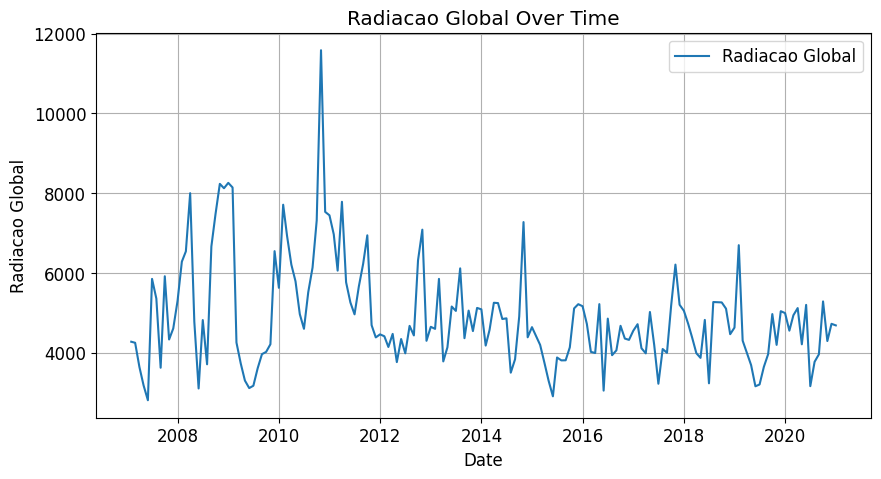

In [42]:
# Custom plot using matplotlib
plt.figure(figsize=(10, 5))
plt.plot(secure_weather_data.index, secure_weather_data['radiacao_global'], label='Radiacao Global')
plt.title('Radiacao Global Over Time')
plt.xlabel('Date')
plt.ylabel('Radiacao Global')
plt.legend()
plt.grid(True)
plt.show()

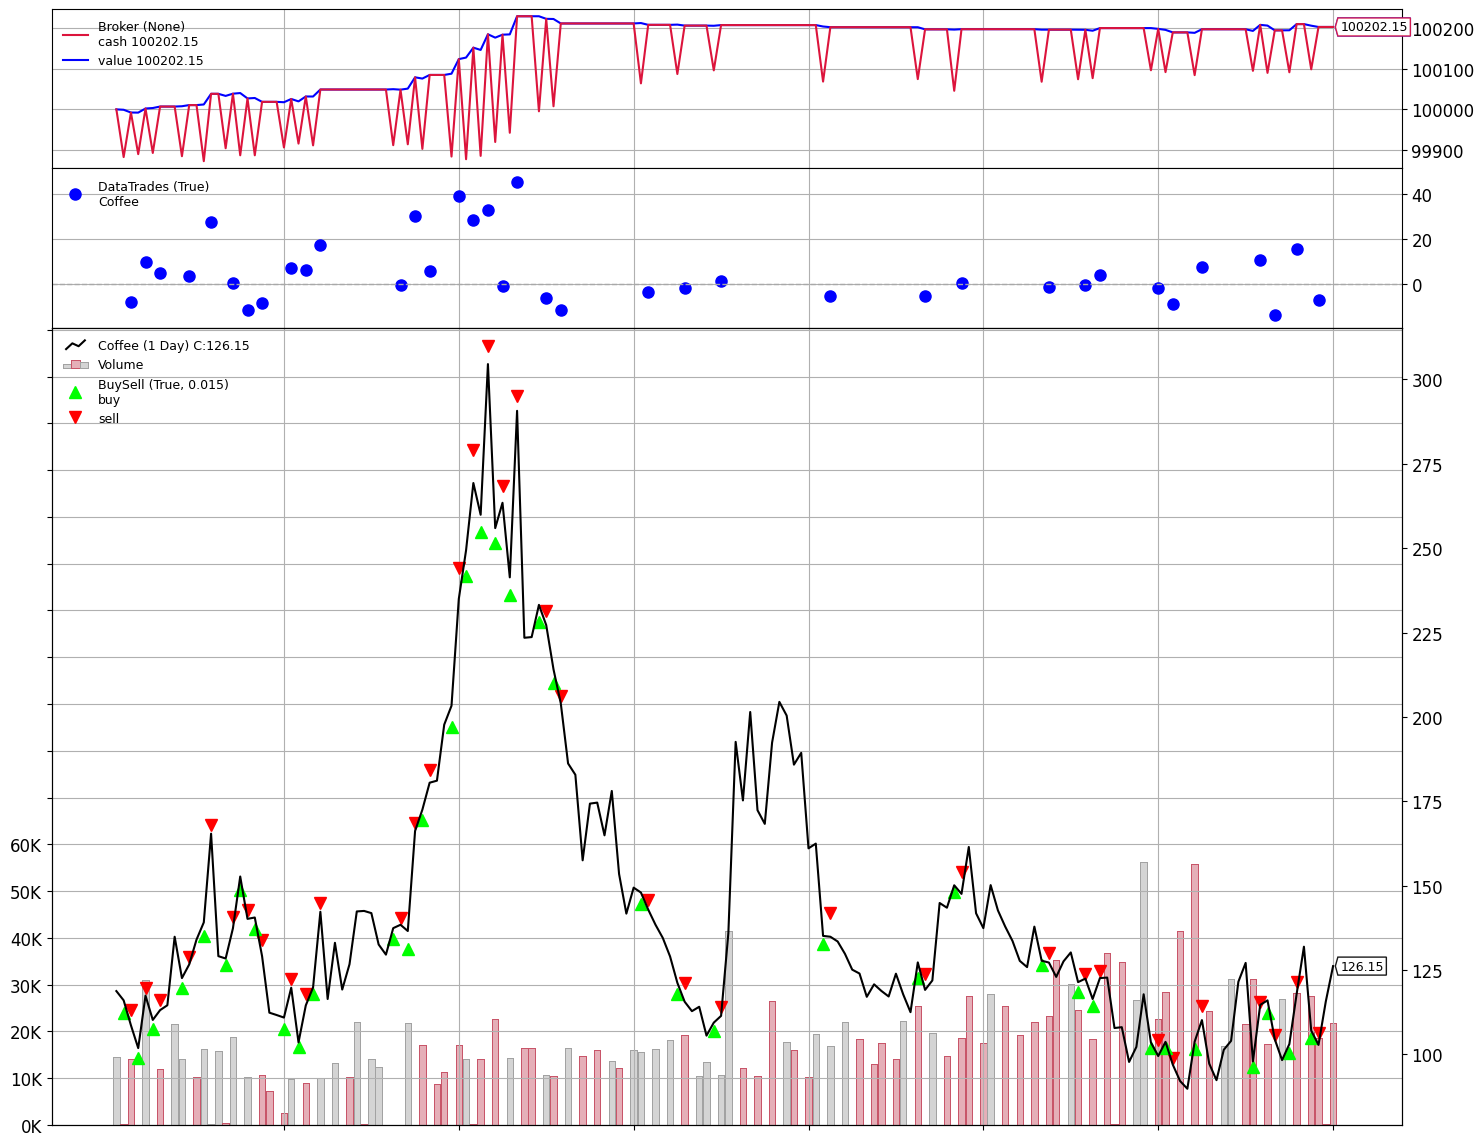

[[<Figure size 1500x1200 with 4 Axes>]]

In [43]:
plt.rcParams['figure.figsize'] = [15, 12]
plt.rcParams.update({'font.size': 12}) 
cerebro.plot(iplot = False)